## Mathematical and Computational Modeling of Suicide as a Complex Dynamical System
#### Authors: Shirley B. Wang, Donald J. Robinaugh, Alexander J. Millner, Rebecca G. Fortgang, Matthew K. Nock

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D
import statistics
from scipy.stats import norm
import random

In [2]:
## figure parameters 
fig_width = 16
fig_height = 6
legend_size = 10
axis_size = 14

# time and time step
t, dt = 20160, 0.01

## Smaller Model: Core Components of the General Escape Theory of Suicide

Black lines indicate positive effects; red lines indicate negative effects.

<center><img src="figures/smallmod_separate_emo.png" style="width: 600px;"></center>

## Full System of Equations

#### Variables
- $S$ = stressors
- $A$ = aversive internal state
- $U$ = urge to escape
- $X$ = escape behavior
- $T$ = suicidal thoughts
- $E$ = external-focused change behaviors
- $I$ = internal-focused change behaviors

#### Equations

Stressors: $S_t = S_0 e^{(\mu - \frac{\sigma^2}{2})t + \sigma W_t - f_1E^+}$

Aversive Internal States: $\frac{dA^+}{dt} = b_2 A^+(K_2-A^+) + a_2S^+ - d_2T^+ - e_2X^+ - g_2I^+$

Urge to Escape: $\frac{dU}{dt} = -c_3U^+ + b_3A^+$

Suicidal Thoughts: $\frac{dT}{dt} = -d_4 T^+ + \frac{1}{1 + e^{-c_{41}(U^+ - c_{42})}}$

Escape Behavior: $\frac{dX}{dt} = -e_5X^+ + \frac{1}{1 + e^{-c_{51}(U^+ - c_{52})}}$

External-Focused Change: $\frac{dE}{dt} = f_6E^+(K_6-E^+) + b_6A^+ - c_6U^+$

Internal-Focused Change: $\frac{dI}{dt} = g_7I^+(K_7-I^+) + b_7A^+ - c_7U^+$

## 1. Stressors only

Geometric Brownian Motion. 

$S_t = S_0 e^{(\mu - \frac{\sigma^2}{2})t + \sigma W_t}$

Desired features of phenomenon: 

- In general, stressors should remain relatively low, with small fluctuations up and down.
- However, stressors *should* sometimes show sharp spikes up and down.
- There should be a fair amount of variability in stressors over time (between and within person).
- Stressors should be above zero.

In [4]:
def geometric_brownian(t, dt, mu, sigma, s0):
    '''
    args:
        t: time period to integrate over
        dt: time step
        mu: drift
        sigma: volatility
        s0: initial value
    '''
    
    stressor = np.zeros(t)
    stressor[0] = s0
    
    for i in range(0, len(stressor) - 1):
        stressor[i + 1] = stressor[i]*np.exp((mu - ((sigma**2)/2))*dt + sigma*np.random.normal(0, np.sqrt(dt)))
        if stressor[i + 1] < 0:
            stressor[i + 1] = 0
    
    return(stressor)

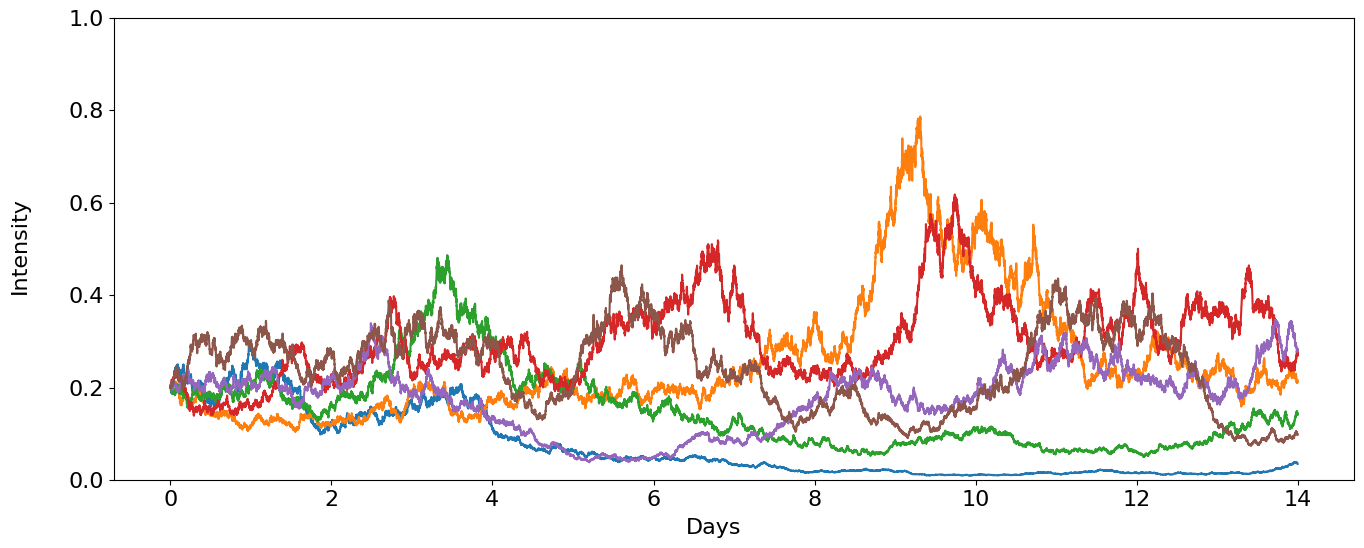

In [5]:
np.random.seed(500)

s0 = 0.2
sigma = 0.1
mu = (sigma**2) / 2
#mu = 0

fig, ax = plt.subplots(1, 1, figsize = (fig_width,fig_height))
for i in range(6):
    stressor = geometric_brownian(t, dt, mu, sigma, s0)
    ax.plot((np.arange(t)/1440), stressor)
    ax.set_ylim([0, 1])
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
fig.text(0.5, 0.02, 'Days', ha='center', fontsize = 16)
fig.text(0.06, 0.5, 'Intensity', va='center', rotation='vertical', fontsize = 16)
#plt.savefig("figures/for_paper/stressor.png", dpi = 300, transparent = True)
plt.show()

## 2. Adding Aversive Internal State

Stressors: $S_t = S_0 e^{(\mu - \frac{\sigma^2}{2})t + \sigma W_t}$

Aversive Internal State: $\frac{dA}{dt} = b_2 A(K-A) + a_2S$

Desired features of phenomena: 

- In general, aversive internal state should closely follow the stressors. When stressors increase, aversive internal state should increase, and when stressors decrease, aversive internal state should decrease. 
- In the absense of stressors, aversive internal state should trend towards a person's "carrying capacity".

In [6]:
def gen_stress_av(t, dt, mu, sigma, s0, A0, b2, K, a2):
    
    stress_av = np.zeros([2, t])
    stress_av[0] = geometric_brownian(t, dt, mu, sigma, s0)
    stress_av[1][0] = A0
    
    for i in range(t - 1):
        stress_av[1][i + 1] = stress_av[1][i] + dt*(b2*stress_av[1][i]*(K - stress_av[1][i]) + a2*stress_av[0][i])
        if stress_av[1][i + 1] < 0:
            stress_av[1][i + 1] = stress_av[1]
    
    return(stress_av)

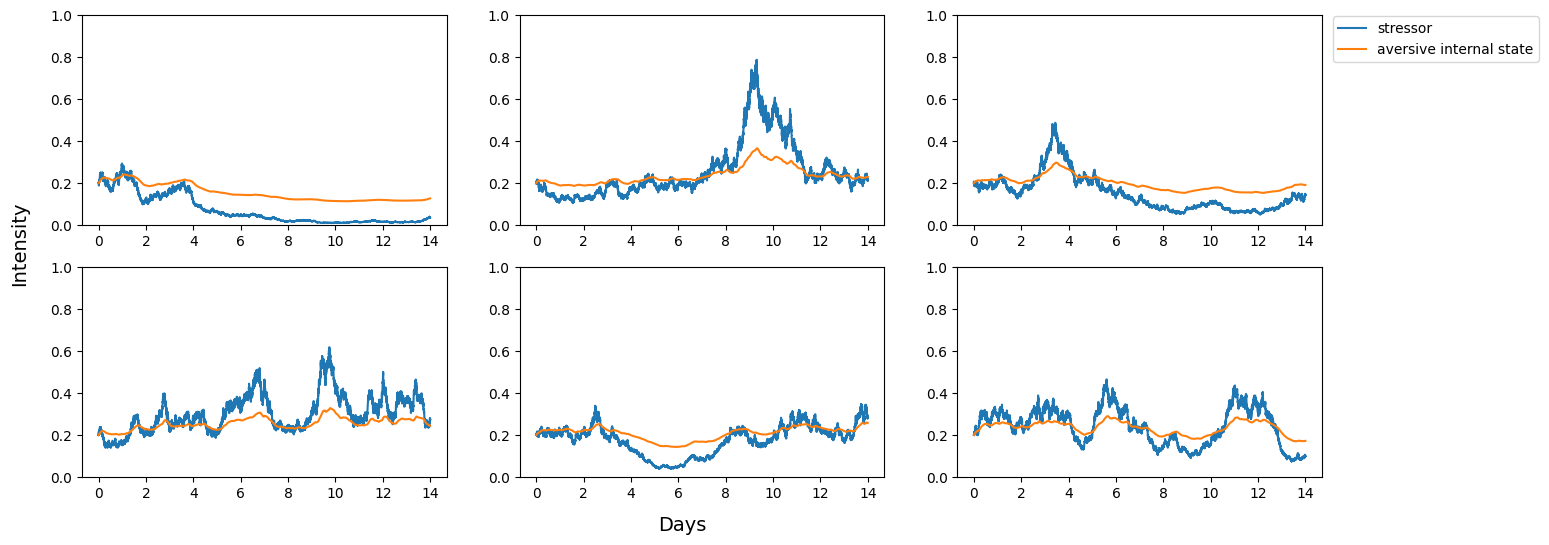

In [7]:
np.random.seed(500)

# stressors
s0 = 0.2
sigma = 0.1
mu = (sigma**2) / 2

# av state params
#A0, b2, K, a2 = 0.2, 1.5, 0.1, 0.5

A0, b2, K, a2 = 0.2, 1.5, 0.1, 0.2

fig, ax = plt.subplots(2, 3, figsize=(fig_width,fig_height), sharey = False)
ax = ax.ravel()
for i in range(6):
    stress_av = gen_stress_av(t, dt, mu, sigma, s0, A0, b2, K, a2)
    ax[i].plot((np.arange(t)/1440), stress_av[0], label = 'stressor')
    ax[i].plot((np.arange(t)/1440), stress_av[1], label = 'aversive internal state')
    ax[i].set_ylim([0, 1])
    if i == 0:
        fig.legend(bbox_to_anchor=(1.04, 0.89), fontsize = legend_size)
fig.text(0.5, 0.02, 'Days', ha='center', fontsize = axis_size)
fig.text(0.08, 0.5, 'Intensity', va='center', rotation='vertical', fontsize = axis_size)
#plt.savefig("figures/for_paper/stressor_av_low.png", dpi = 300, transparent = True, bbox_inches='tight')
plt.show()

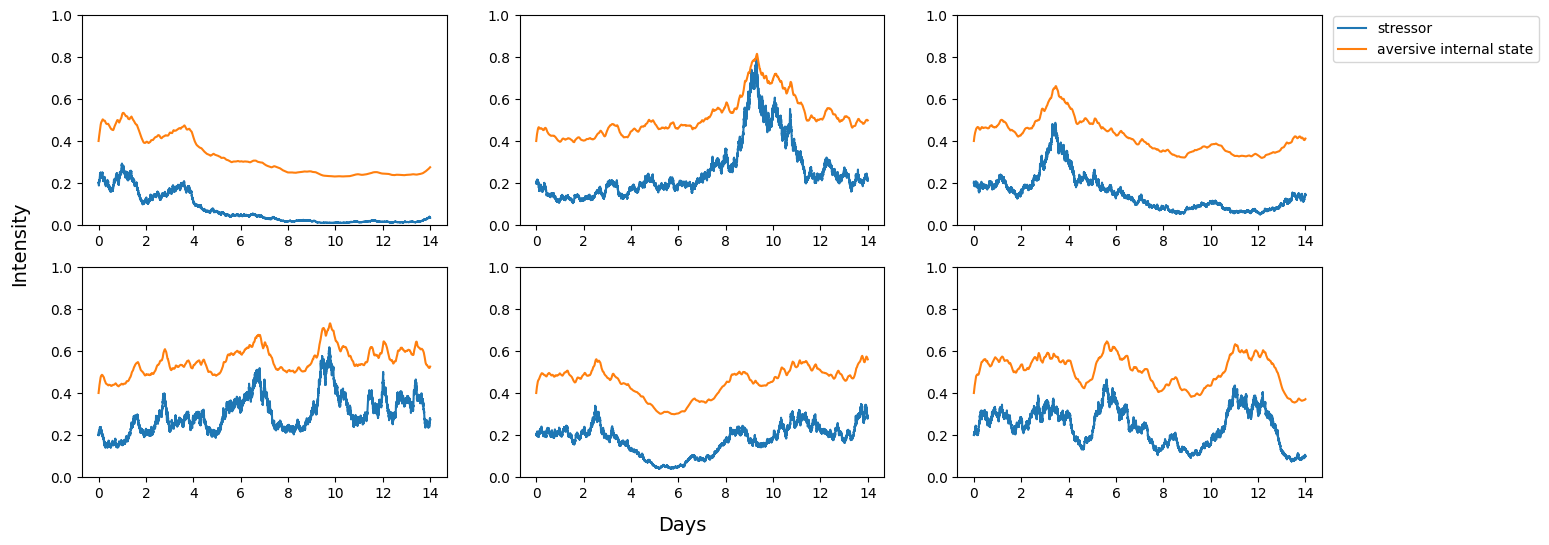

In [8]:
np.random.seed(500)

# higher negative affectivity

A0, K, a2 = 0.4, 0.2, 1

fig, ax = plt.subplots(2, 3, figsize=(fig_width,fig_height), sharey = False)
ax = ax.ravel()
for i in range(6):
    stress_av = gen_stress_av(t, dt, mu, sigma, s0, A0, b2, K, a2)
    ax[i].plot((np.arange(t)/1440), stress_av[0], label = 'stressor')
    ax[i].plot((np.arange(t)/1440), stress_av[1], label = 'aversive internal state')
    ax[i].set_ylim([0, 1])
    if i == 0:
        fig.legend(bbox_to_anchor=(1.04, 0.89), fontsize = legend_size)
fig.text(0.5, 0.02, 'Days', ha='center', fontsize = axis_size)
fig.text(0.08, 0.5, 'Intensity', va='center', rotation='vertical', fontsize = axis_size)
#plt.savefig("figures/for_paper/stressor_av_high.png", dpi = 300, transparent = True, bbox_inches='tight')
plt.show()

## 3. Adding Urge to Escape

Stressors: $S_t = S_0 e^{(\mu - \frac{\sigma^2}{2})t + \sigma W_t}$

Aversive internal state: $\frac{dA}{dt} = b_2 A(K-A) + a_2S$ 

Urge to Escape: $\frac{dU}{dt} = -c_3U + b_3A$

Desired features of phenomena: 

- In general, urge to escape should follow aversive internal state. When aversive internal state increases, urge to escape should increase, and when aversive internal state decreases, urge to escape should decrease.


In [9]:
def gen_stress_av_urge(t, dt, mu, sigma, s0, A0, b2, K, a2, u0, b3, c3):
    
    stress_av_urge = np.zeros([3, t])
    stress_av_urge[0:2, ] = gen_stress_av(t, dt, mu, sigma, s0, A0, b2, K, a2)
    stress_av_urge[2][0] = u0
    
    for i in range(t - 1):
        stress_av_urge[2][i + 1] = dt*(-c3*stress_av_urge[2][i] + b3*stress_av_urge[1][i]) + stress_av_urge[2][i]
        if stress_av_urge[2][i + 1] < 0:
            stress_av_urge[2][i + 1] = 0
    
    return(stress_av_urge)

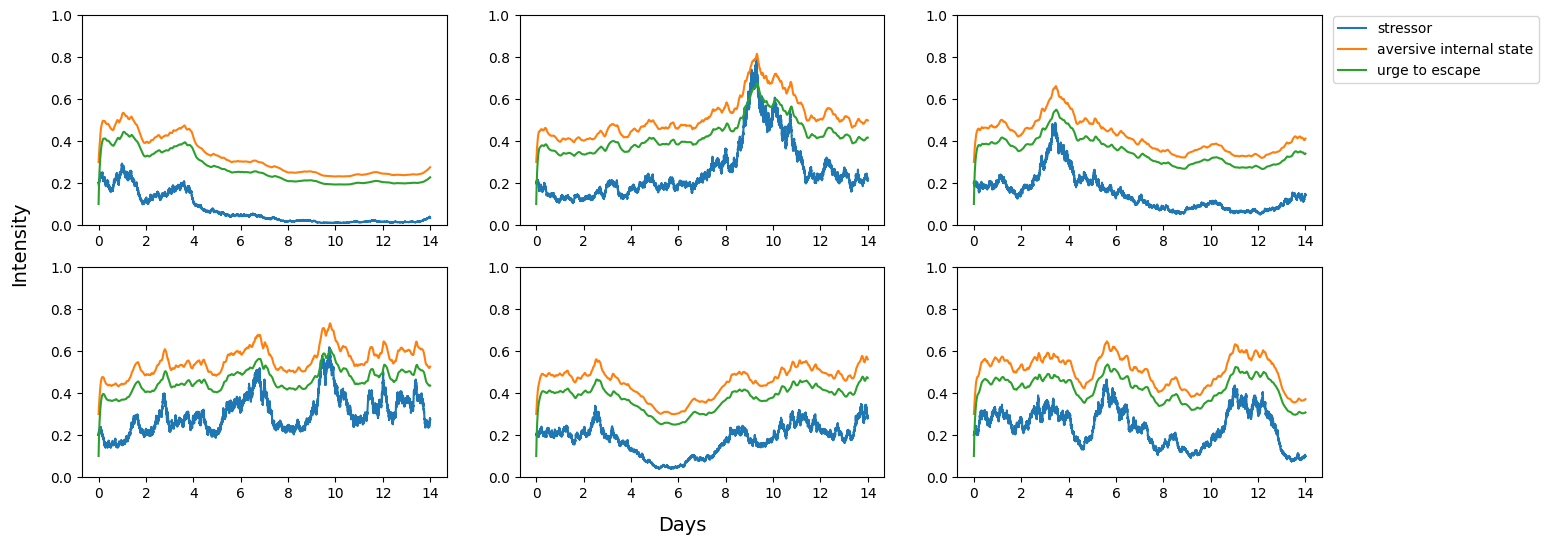

In [10]:
np.random.seed(500)

# stressors
s0 = 0.2
sigma = 0.1
mu = (sigma**2) / 2

# av state params
A0, b2, K, a2 = 0.3, 1.5, 0.2, 1

# urge to escape params
u0, b3, c3 = 0.1, 2.5, 3

fig, ax = plt.subplots(2, 3, figsize=(fig_width,fig_height), sharey = False)
ax = ax.ravel()
for i in range(6): 
    stress_av_urge = gen_stress_av_urge(t, dt, mu, sigma, s0, A0, b2, K, a2, u0, b3, c3)
    ax[i].plot((np.arange(t)/1440), stress_av_urge[0], label = 'stressor')
    ax[i].plot((np.arange(t)/1440), stress_av_urge[1], label = 'aversive internal state')
    ax[i].plot((np.arange(t)/1440), stress_av_urge[2], label = 'urge to escape')
    ax[i].set_ylim([0, 1])
    if i == 0:
        fig.legend(bbox_to_anchor=(1.04, 0.89), fontsize = legend_size)
fig.text(0.5, 0.02, 'Days', ha='center', fontsize = axis_size)
fig.text(0.08, 0.5, 'Intensity', va='center', rotation='vertical', fontsize = axis_size)
#plt.savefig("figures/for_paper/stressor_av_urge.png", dpi = 300, transparent = True, bbox_inches='tight')
plt.show()

## 4. Adding Suicidal Thoughts

Stressors: $S_t = S_0 e^{(\mu - \frac{\sigma^2}{2})t + \sigma W_t}$

Aversive Internal State: $\frac{dA}{dt} = b_2 A(K-A) + a_2S - d_2T$

Urge to Escape: $\frac{dU}{dt} = -c_3U + b_3A$

Suicidal Thoughts: $\frac{dT}{dt} = -d_4 T + \frac{1}{1 + e^{-c_{41}(U - c_{42})}}$

Desired features of phenomena: 

- Unlike aversive internal state and urge to escape, suicidal thoughts shold *not* directly follow stressors. 
- Given what we know from EMA studies, suicidal thoughts should have a relatively fast onset, and short duration. 
- In addition, given what we know from EMA studies, suicidal thoughts should be zero-inflated.

In [11]:
def gen_stress_av_urge_si(t, dt, mu, sigma, s0, A0, b2, K, a2, u0, b3, c3, t0, c41, c42, d4, d2):
    
    stress_av_urge_si = np.zeros([4, t])
    stress_av_urge_si[0] = geometric_brownian(t, dt, mu, sigma, s0)
    stressor = stress_av_urge_si[0]
    
    av_state = stress_av_urge_si[1]
    urge_escape = stress_av_urge_si[2]
    sui_thoughts = stress_av_urge_si[3]
    
    av_state[0] = A0
    urge_escape[0] = u0
    sui_thoughts[0] = t0
    
    for i in range(t - 1):
        ## aversive internal state including negative effect of suicidal thoughts
        av_state[i + 1] = av_state[i] + dt*(b2*av_state[i]*(K - av_state[i]) + a2*stressor[i] - d2*sui_thoughts[i])
        #if av_state[i + 1] < 0:
        #    av_state[i + 1] = 0
        
        ## urge to escape
        urge_escape[i + 1] = urge_escape[i] + dt*(-c3*urge_escape[i] + b3*av_state[i])
        #if urge_escape[i + 1] < 0:
        #    urge_escape[i + 1] = 0
        
        ## suicidal thoughts
        sui_thoughts[i + 1] = sui_thoughts[i] + dt*(-d4*sui_thoughts[i] + (1 / (1 + np.exp(-c41 * (urge_escape[i] - c42)))))
        #if sui_thoughts[i + 1] < 0:
        #    sui_thoughts[i + 1] = 0
    
    return(stress_av_urge_si)

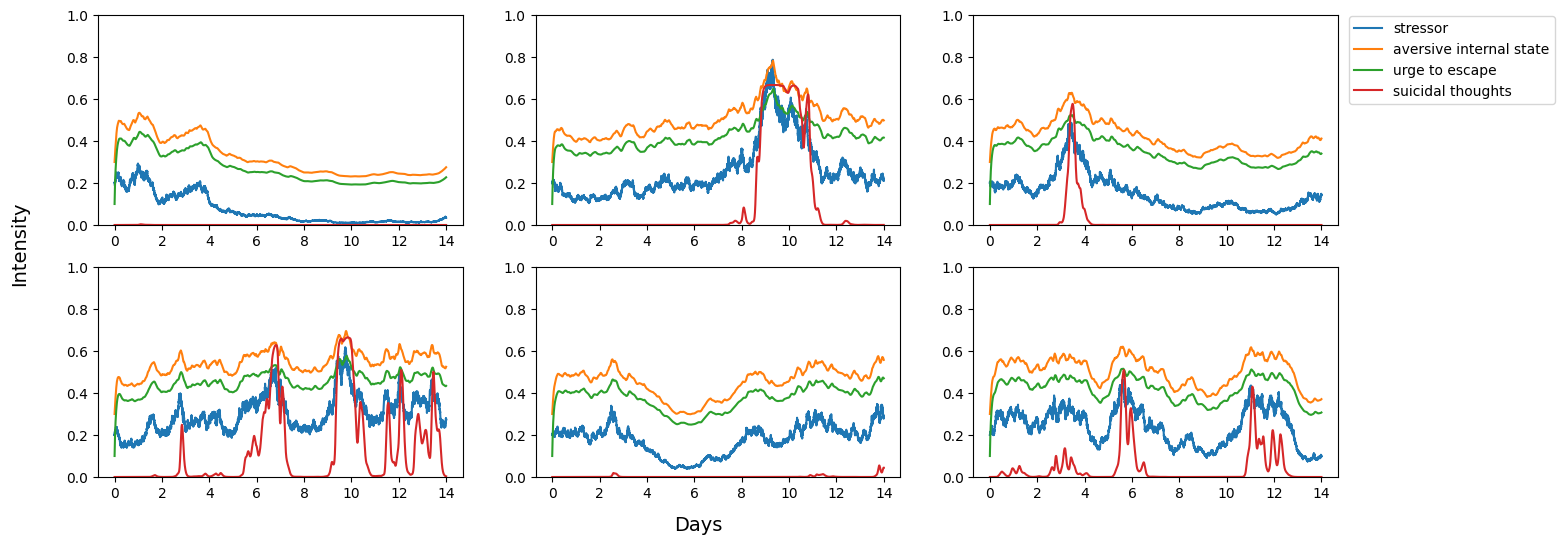

In [12]:
np.random.seed(500)

# stressors
s0 = 0.2
sigma = 0.1
mu = (sigma**2) / 2

# av state params
A0, b2, K, a2 = 0.3, 1.5, 0.2, 1

# urge to escape params
u0, b3, c3 = 0.1, 2.5, 3

# suicidal thoughts params
t0, c41, c42, d4, d2 = 0, 90, 0.5, 1.5, 0.1

fig, ax = plt.subplots(2, 3, figsize=(fig_width,fig_height), sharey = False)
ax = ax.ravel()
for i in range(6): 
    stress_av_urge_si = gen_stress_av_urge_si(t, dt, mu, sigma, s0, A0, b2, K, a2, u0, b3, c3, t0, c41, c42, d4, d2)
    ax[i].plot((np.arange(t)/1440), stress_av_urge_si[0], label = 'stressor')
    ax[i].plot((np.arange(t)/1440), stress_av_urge_si[1], label = 'aversive internal state')
    ax[i].plot((np.arange(t)/1440), stress_av_urge_si[2], label = 'urge to escape')
    ax[i].plot((np.arange(t)/1440), stress_av_urge_si[3], label = 'suicidal thoughts')
    ax[i].set_ylim([0, 1])
    if i == 0:
        fig.legend(bbox_to_anchor=(1.04, 0.89), fontsize = legend_size)
fig.text(0.5, 0.02, 'Days', ha='center', fontsize =  axis_size)
fig.text(0.07, 0.5, 'Intensity', va='center', rotation='vertical', fontsize = axis_size)
#plt.savefig("figures/for_paper/stressor_av_urge_sui.png", dpi = 300, transparent = True, bbox_inches='tight')
plt.show()

## 5. Adding other short-term escape behaviors

Stressors: $S_t = S_0 e^{(\mu - \frac{\sigma^2}{2})t + \sigma W_t}$

Aversive Internal State: $\frac{dA}{dt} = b_2 A(K-A) + a_2S - d_2T - e_2O$

Urge to Escape: $\frac{dU}{dt} = -c_3U + b_3A$

Suicidal Thoughts: $\frac{dT}{dt} = -d_4 T + \frac{1}{1 + e^{-c_{41}(U - c_{42})}}$

Other Short-Term Escape: $\frac{dO}{dt} = -e_5O + \frac{1}{1 + e^{-c_{51}(U - c_{52})}}$

Desired feature of phenomena: 

- A core component of our theory (General Escape Theory of Suicide) is that suicidal thoughts should *not* emerge when other escape behaviors are effectively regulating aversive internal state. 
- Therefore, when the parameter governing the effect of other escape behaviors on change in aversive internal state over time ($e_2$ parameter) is *large*, suicidal thoughts should not emerge.
- On the other hand, when the $e_2$ parameter is *small*, suicidal thoughts should emerge (not all the time, but sometimes).


In [14]:
def gen_stress_av_urge_si_other(t, dt, mu, sigma, s0, A0, b2, K, a2, u0, b3, c3, t0, c41, c42, d4, d2, o0, e5, c51, c52, e2):
    
    stress_av_urge_si_oth = np.zeros([5, t])
    stress_av_urge_si_oth[0] = geometric_brownian(t, dt, mu, sigma, s0)
    stressor = stress_av_urge_si_oth[0]
    
    av_state = stress_av_urge_si_oth[1]
    urge_escape = stress_av_urge_si_oth[2]
    sui_thoughts = stress_av_urge_si_oth[3]
    other_escape = stress_av_urge_si_oth[4]
    
    av_state[0] = A0
    urge_escape[0] = u0
    sui_thoughts[0] = t0
    other_escape[0] = o0
    
    for i in range(t - 1):
        ## aversive internal state including negative effect of suicidal thoughts
        av_state[i + 1] = av_state[i] + dt*(b2*av_state[i]*(K - av_state[i]) + a2*stressor[i] - d2*sui_thoughts[i] - e2*other_escape[i])
        if av_state[i + 1] < 0:
            av_state[i + 1] = 0
            
        ## urge to escape
        urge_escape[i + 1] = urge_escape[i] + dt*(-c3*urge_escape[i] + b3*av_state[i])
        if urge_escape[i + 1] < 0:
            urge_escape[i + 1] = 0
        
        ## suicidal thoughts
        sui_thoughts[i + 1] = sui_thoughts[i] + dt*(-d4*sui_thoughts[i] + (1 / (1 + np.exp(-c41 * (urge_escape[i] - c42)))))
        if sui_thoughts[i + 1] < 0:
            sui_thoughts[i + 1] = 0
        
        ## other escape behaviors 
        other_escape[i + 1] = other_escape[i] + dt*(-e5*other_escape[i] + (1 / (1 + np.exp(-c51 * (urge_escape[i] - c52)))))
        if other_escape[i + 1] < 0:
            other_escape[i + 1] = 0
    
    return(stress_av_urge_si_oth)

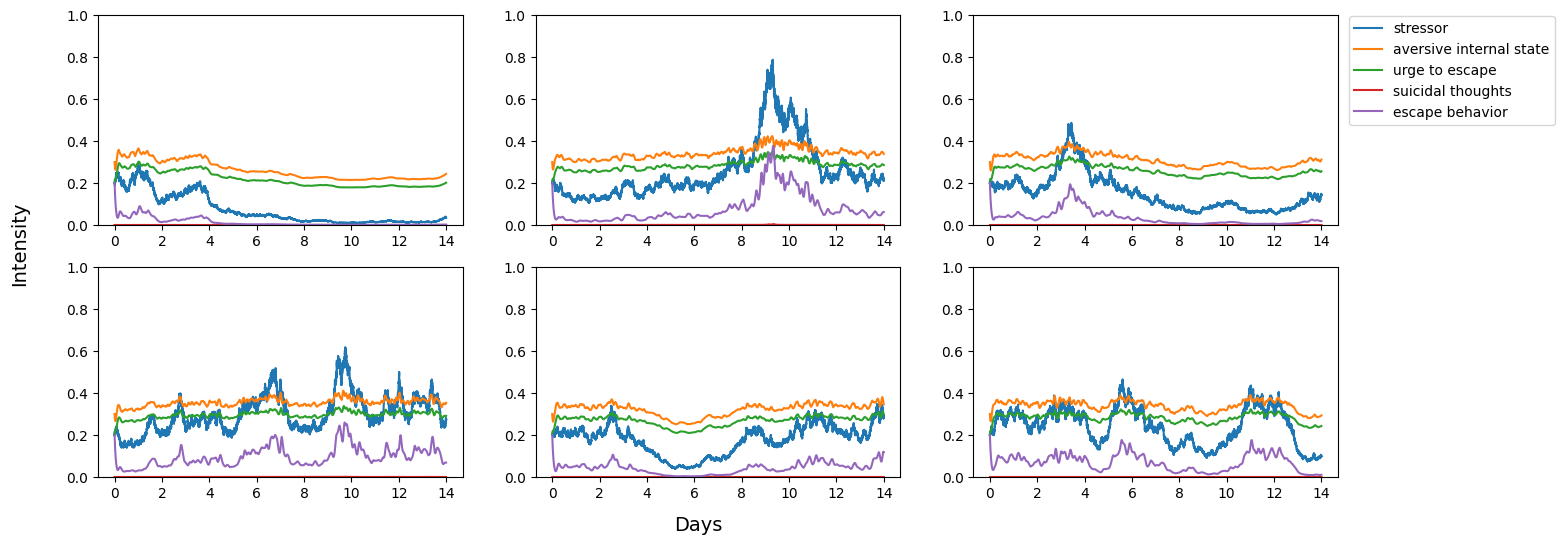

In [16]:
np.random.seed(500)

# stressors
s0 = 0.2
sigma = 0.1
mu = (sigma**2) / 2

# av state params
A0, b2, K, a2 = 0.3, 3, 0.2, 1

# urge to escape params
u0, b3, c3 = 0.2, 2.5, 3

# suicidal thoughts params
t0, c41, c42, d4, d2 = 0, 100, 0.4, 1, 0.2

# other escape params
o0, e5, c51, c52, e2 = 0.2, 1.2, 40, 0.35, 1.4

fig, ax = plt.subplots(2, 3, figsize=(fig_width,fig_height), sharey = False)
ax = ax.ravel()
for i in range(6): 
    stress_av_urge_si_other = gen_stress_av_urge_si_other(t = t, dt = dt, mu = mu, sigma = sigma, s0 = s0, 
                                                          A0 = A0, b2 = b2, K = K, a2 = a2, u0 = u0, b3 = b3, c3 = c3, 
                                                          t0 = t0, c41 = c41, c42 = c42, d4 = d4, d2 = d2, 
                                                          o0 = o0, e5 = e5, c51 = c51, c52 = c52, e2 = e2)
    ax[i].plot((np.arange(t)/1440), stress_av_urge_si_other[0], label = 'stressor')
    ax[i].plot((np.arange(t)/1440), stress_av_urge_si_other[1], label = 'aversive internal state')
    ax[i].plot((np.arange(t)/1440), stress_av_urge_si_other[2], label = 'urge to escape')
    ax[i].plot((np.arange(t)/1440), stress_av_urge_si_other[3], label = 'suicidal thoughts')
    ax[i].plot((np.arange(t)/1440), stress_av_urge_si_other[4], label = 'escape behavior')
    ax[i].set_ylim([0, 1])
    if i == 0:
        fig.legend(bbox_to_anchor=(1.04, 0.89), fontsize = legend_size)
fig.text(0.5, 0.02, 'Days', ha='center', fontsize =  axis_size)
fig.text(0.07, 0.5, 'Intensity', va='center', rotation='vertical', fontsize = axis_size)
#plt.savefig("figures/for_paper/stressor_av_urge_sui_oth_eff.png", dpi = 300, transparent = True, bbox_inches='tight')
plt.show()

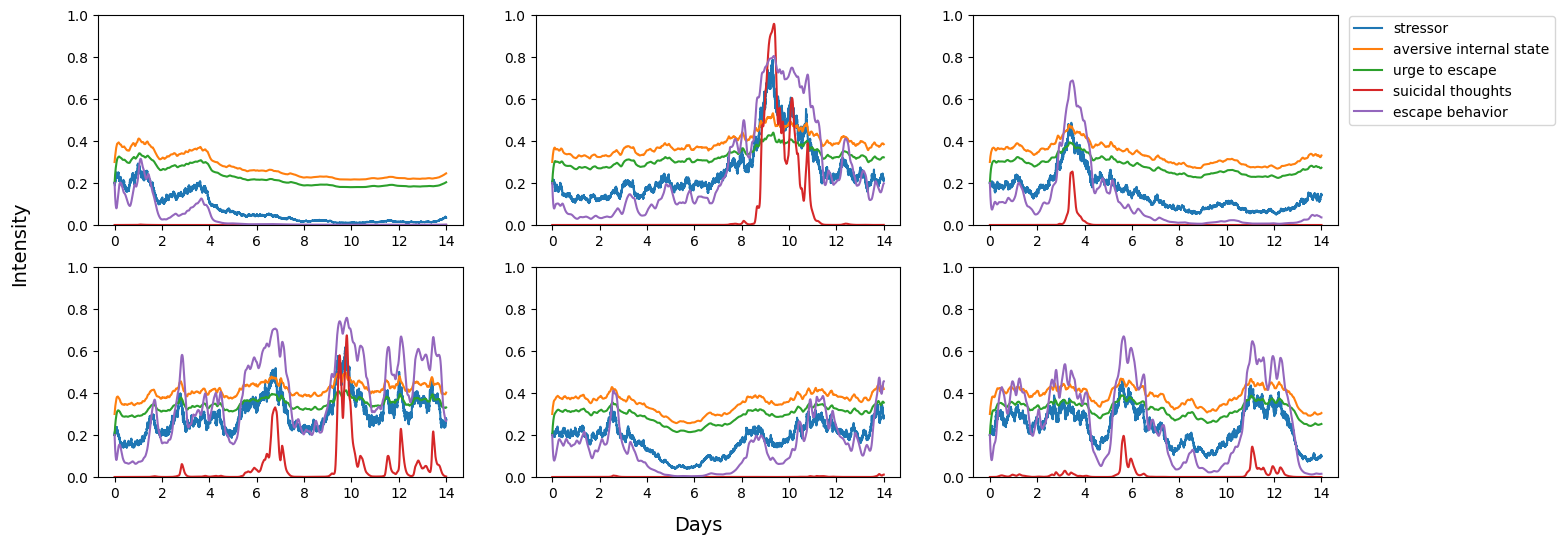

In [18]:
np.random.seed(500)

e2 = 0.05

fig, ax = plt.subplots(2, 3, figsize=(fig_width,fig_height), sharey = False)
ax = ax.ravel()
for i in range(6): 
    stress_av_urge_si_other = gen_stress_av_urge_si_other(t = t, dt = dt, mu = mu, sigma = sigma, s0 = s0, 
                                                          A0 = A0, b2 = b2, K = K, a2 = a2, u0 = u0, b3 = b3, c3 = c3, 
                                                          t0 = t0, c41 = c41, c42 = c42, d4 = d4, d2 = d2, 
                                                          o0 = o0, e5 = e5, c51 = c51, c52 = c52, e2 = e2)
    ax[i].plot((np.arange(t)/1440), stress_av_urge_si_other[0], label = 'stressor')
    ax[i].plot((np.arange(t)/1440), stress_av_urge_si_other[1], label = 'aversive internal state')
    ax[i].plot((np.arange(t)/1440), stress_av_urge_si_other[2], label = 'urge to escape')
    ax[i].plot((np.arange(t)/1440), stress_av_urge_si_other[3], label = 'suicidal thoughts')
    ax[i].plot((np.arange(t)/1440), stress_av_urge_si_other[4], label = 'escape behavior')
    ax[i].set_ylim([0, 1])
    if i == 0:
        fig.legend(bbox_to_anchor=(1.04, 0.89), fontsize = legend_size)
fig.text(0.5, 0.02, 'Days', ha='center', fontsize =  axis_size)
fig.text(0.07, 0.5, 'Intensity', va='center', rotation='vertical', fontsize = axis_size)
#plt.savefig("figures/for_paper/stressor_av_urge_sui_oth_not_eff.png", dpi = 300, transparent = True, bbox_inches='tight')
plt.show()

## Full Model 

In [19]:
def gen_suicide_sim(t, dt, mu, sigma, S0, 
                    A0, K2, b2, a2, d2, e2, g2,
                    U0, c3, b3,
                    T0, d4, c41, c42, 
                    O0, e5, c51, c52,
                    E0, K6, f6, b6, c6, 
                    I0, K7, g7, b7, c7):
    
    model_sim = np.zeros([7, t])
    
    stressor, stressor[0] = model_sim[0], S0
    av_state, av_state[0] = model_sim[1], A0
    urge_escape, urge_escape[0] = model_sim[2], U0
    sui_thoughts, sui_thoughts[0] = model_sim[3], T0
    other_escape, other_escape[0] = model_sim[4], O0
    ext_change, ext_change[0] = model_sim[5], E0
    int_change, int_change[0] = model_sim[6], I0
            
    for i in range(t - 1):
            
        ## stressor and effect of long-term change
        stressor[i + 1] = stressor[i]*np.exp((mu - ((sigma**2)/2))*dt + sigma*np.random.normal(0, np.sqrt(dt)) - f1*ext_change[i])
        if stressor[i + 1] < 0:
            stressor[i + 1] = 0
        
        ## aversive internal state including negative effect of suicidal thoughts
        av_state[i + 1] = av_state[i] + dt*(b2*av_state[i]*(K2 - av_state[i]) + a2*stressor[i] - d2*sui_thoughts[i] - e2*other_escape[i] - g2*int_change[i])
        if av_state[i + 1] < 0:
            av_state[i + 1] = 0
            
        ## urge to escape
        urge_escape[i + 1] = urge_escape[i] + dt*(-c3*urge_escape[i] + b3*av_state[i]) # + 5*dt*new_effect OR really weak new_effect
        if urge_escape[i + 1] < 0:
            urge_escape[i + 1] = 0
            
        ## suicidal thoughts
        sui_thoughts[i + 1] = sui_thoughts[i] + dt*(-d4*sui_thoughts[i] + (1 / (1 + np.exp(-c41 * (urge_escape[i] - c42)))))
        if sui_thoughts[i + 1] < 0:
            sui_thoughts[i + 1] = 0
            
        ## other escape behaviors 
        other_escape[i + 1] = other_escape[i] + dt*(-e5*other_escape[i] + (1 / (1 + np.exp(-c51 * (urge_escape[i] - c52)))))
        if other_escape[i + 1] < 0:
            other_escape[i + 1] = 0
            
        ## external-focused change
        ext_change[i + 1] = ext_change[i] + dt*(f6*ext_change[i]*(K6 - ext_change[i]) + b6*av_state[i] - c6*urge_escape[i])
        if ext_change[i + 1] < 0:
            ext_change[i + 1] = 0
            
        ## internal-focused change
        int_change[i + 1] = int_change[i] + dt*(g7*int_change[i]*(K7 - int_change[i]) + b7*av_state[i] - c7*urge_escape[i])
        if int_change[i + 1] < 0:
            int_change[i + 1] = 0  
    
    return(model_sim)

In [20]:
def set_params(stressor_setting):
    
    if stressor_setting == "low":
        sigma = 0.05
        S0, mu, f1 = 0.2, ((sigma**2) / 2), 0.0001

    if stressor_setting == "medium":
        sigma = 0.1
        S0, mu, f1 = 0.2, ((sigma**2) / 2), 0.0001
        
    if stressor_setting == "high":
        sigma = 0.12
        S0, mu, f1 = 0.2, ((sigma**2) / 2), 0.0001
    
    # neg affect params (b2, k2, a2, d2, e2, g2)
    A0, K2, b2, a2, d2, e2, g2 = 0.3, 0.2, 4, 2, 1.5, 1, 0.5

    # urge to escape params
    U0, b3, c3 = 0.25, 1.5, 3

    # suicidal thoughts params
    T0, d4, c41, c42 = 0, 1, 100, 0.25

    # other escape params
    O0, e5, c51, c52 = 0.2, 3, 50, 0.2

    # external-focused changed params
    E0, K6, f6, b6, c6 = 0.05, 0.1, 0.5, 0.41, 0.82

    # internal-focused change params
    I0, K7, g7, b7, c7 =  0.1, 0.05, 0.5, 0.65, 1.3
    
    return S0, mu, sigma, f1, A0, K2, b2, a2, d2, e2, g2, U0, c3, b3, T0, d4, c41, c42, O0, e5, c51, c52, E0, K6, f6, b6, c6, I0, K7, g7, b7, c7, E0, K6, f6, b6, c6 

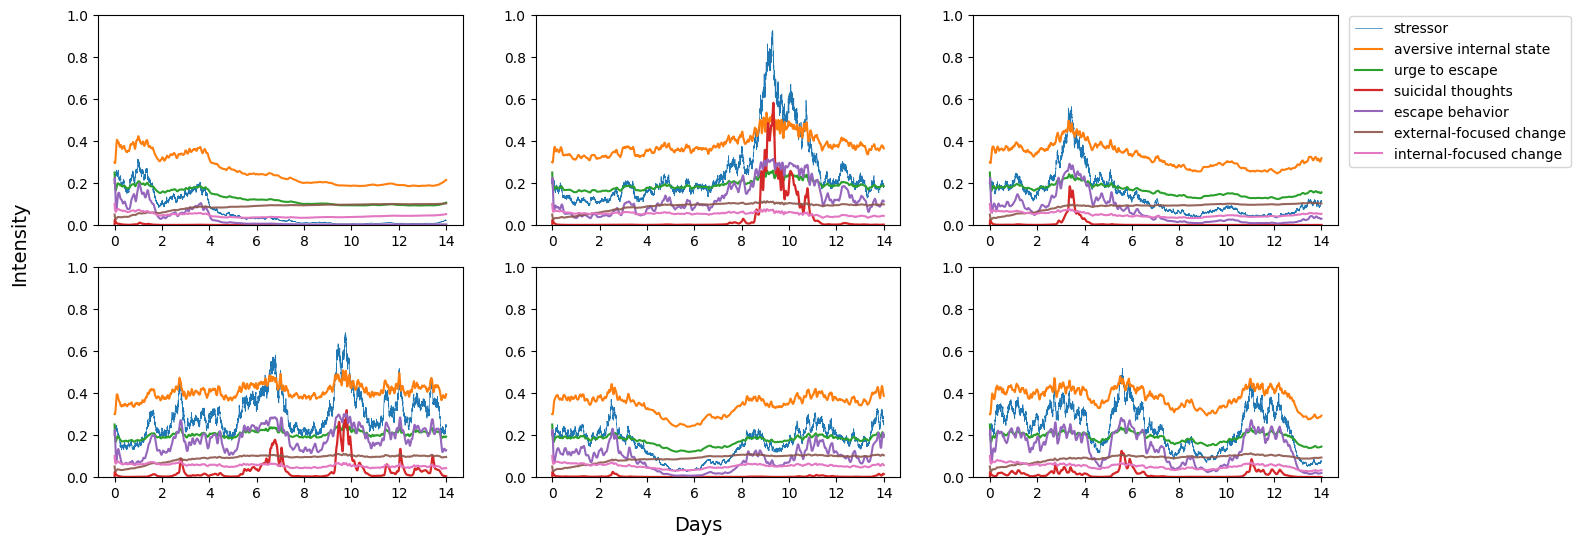

In [21]:
# low engagement in strategies
np.random.seed(500)

S0, mu, sigma, f1, A0, K2, b2, a2, d2, e2, g2, U0, c3, b3, T0, d4, c41, c42, \
O0, e5, c51, c52, E0, K6, f6, b6, c6, I0, K7, g7, b7, c7, E0, K6, f6, b6, c6 = set_params("high")

fig, ax = plt.subplots(2, 3, figsize=(fig_width,fig_height), sharey = False)
ax = ax.ravel()
for i in range(6): 
    sui_model_sim = gen_suicide_sim(t=t, dt=dt, mu=mu, sigma=sigma, S0=S0, 
                                    A0=A0, K2=K2, b2=b2, a2=a2, d2=d2, e2=e2, g2=g2,
                                    U0=U0, c3=c3, b3=b3,
                                    T0=T0, d4=d4, c41=c41, c42=c42, 
                                    O0=O0, e5=e5, c51=c51, c52=c52,
                                    E0=E0, K6=K6, f6=f6, b6=b6, c6=c6, 
                                    I0=I0, K7=K7, g7=g7, b7=b7, c7=c7)
    ax[i].plot((np.arange(t)/1440), sui_model_sim[0], label = 'stressor', linewidth = 0.5)
    ax[i].plot((np.arange(t)/1440), sui_model_sim[1], label = 'aversive internal state')
    ax[i].plot((np.arange(t)/1440), sui_model_sim[2], label = 'urge to escape')
    ax[i].plot((np.arange(t)/1440), sui_model_sim[3], label = 'suicidal thoughts', linewidth = 1.6)
    ax[i].plot((np.arange(t)/1440), sui_model_sim[4], label = 'escape behavior')
    ax[i].plot((np.arange(t)/1440), sui_model_sim[5], label = 'external-focused change', alpha = 0.9)
    ax[i].plot((np.arange(t)/1440), sui_model_sim[6], label = 'internal-focused change')
    ax[i].set_ylim([0, 1])
    if i == 0:
        fig.legend(bbox_to_anchor=(1.05, 0.89), fontsize = legend_size)
fig.text(0.5, 0.02, 'Days', ha='center', fontsize =  axis_size)
fig.text(0.07, 0.5, 'Intensity', va='center', rotation='vertical', fontsize = axis_size)
#plt.savefig("figures/for_paper/lowstrategies.png", dpi = 300, transparent = True, bbox_inches='tight')
plt.show()

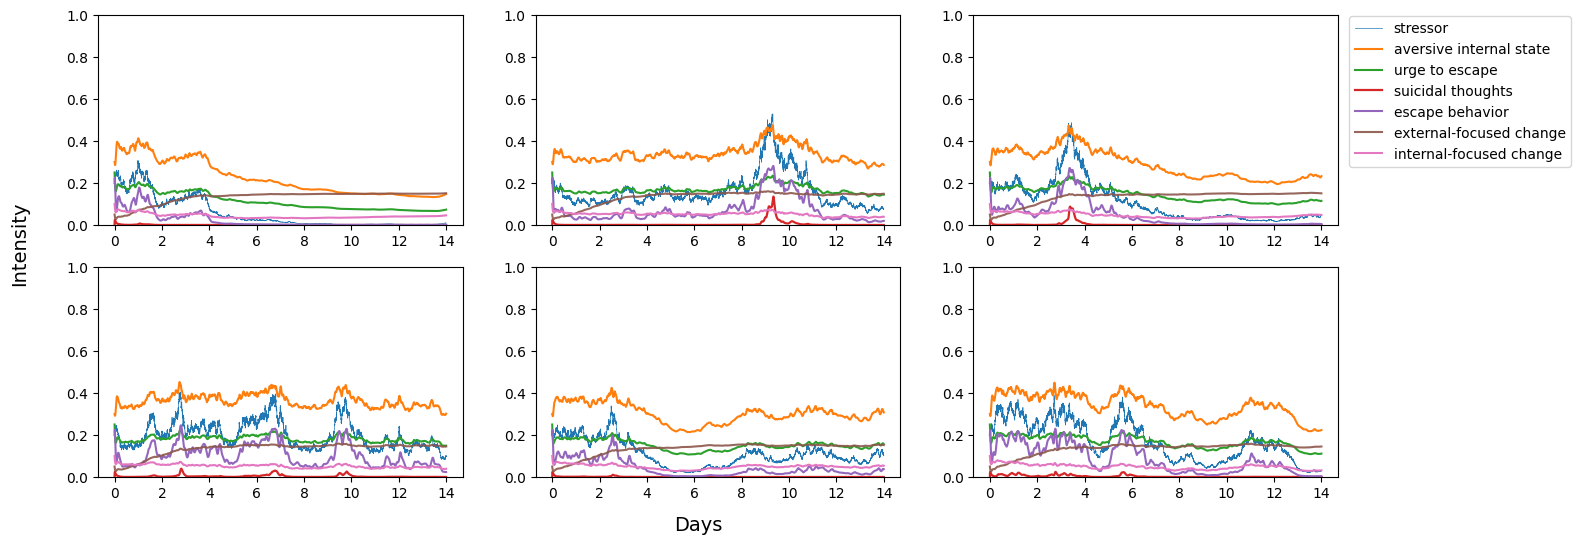

In [22]:
np.random.seed(500)

# high engagement in strategies 
f1 = 0.0004
g2 = 1
K6, K7 = 0.15, 0.05

fig, ax = plt.subplots(2, 3, figsize=(fig_width,fig_height), sharey = False)
ax = ax.ravel()
for i in range(6): 
    sui_model_sim = gen_suicide_sim(t=t, dt=dt, mu=mu, sigma=sigma, S0=S0, 
                                    A0=A0, K2=K2, b2=b2, a2=a2, d2=d2, e2=e2, g2=g2,
                                    U0=U0, c3=c3, b3=b3,
                                    T0=T0, d4=d4, c41=c41, c42=c42, 
                                    O0=O0, e5=e5, c51=c51, c52=c52,
                                    E0=E0, K6=K6, f6=f6, b6=b6, c6=c6, 
                                    I0=I0, K7=K7, g7=g7, b7=b7, c7=c7)
    ax[i].plot((np.arange(t)/1440), sui_model_sim[0], label = 'stressor', linewidth = 0.5)
    ax[i].plot((np.arange(t)/1440), sui_model_sim[1], label = 'aversive internal state')
    ax[i].plot((np.arange(t)/1440), sui_model_sim[2], label = 'urge to escape')
    ax[i].plot((np.arange(t)/1440), sui_model_sim[3], label = 'suicidal thoughts', linewidth = 1.6)
    ax[i].plot((np.arange(t)/1440), sui_model_sim[4], label = 'escape behavior')
    ax[i].plot((np.arange(t)/1440), sui_model_sim[5], label = 'external-focused change', alpha = 0.9)
    ax[i].plot((np.arange(t)/1440), sui_model_sim[6], label = 'internal-focused change')
    ax[i].set_ylim([0, 1])
    if i == 0:
        fig.legend(bbox_to_anchor=(1.05, 0.89), fontsize = legend_size)
fig.text(0.5, 0.02, 'Days', ha='center', fontsize =  axis_size)
fig.text(0.07, 0.5, 'Intensity', va='center', rotation='vertical', fontsize = axis_size)
#plt.savefig("figures/for_paper/highstrategies.png", dpi = 300, transparent = True, bbox_inches='tight')
plt.show()